In [1]:
# %matplotlib
# %matplotlib inline
# %matplotlib notebook

import pandas as pd
import numpy as np
import random
import os
import warnings
from datetime import datetime, timedelta, timezone
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FormatStrFormatter
import re
import math
from copy import deepcopy
from numba_stats import t
import scipy.stats as stats

import gridmeter as gm

from IPython.display import Image, Markdown, display
plt.ion()
plt.rcParams['figure.figsize'] = [24, 16]
plt.rcParams['figure.dpi'] = 300

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)

%load_ext autoreload
%autoreload 2

In [2]:
df_ls_t = pd.read_csv("/app/.recurve_cache/clustering/example_dfs/df_ls_t.csv")
df_ls_cp = pd.read_csv("/app/.recurve_cache/clustering/example_dfs/df_ls_cp.csv")

df_ls_t = df_ls_t.rename(columns={"hour": "time", "ls": "loadshape"})
df_ls_cp = df_ls_cp.rename(columns={"hour": "time", "ls": "loadshape"})

data_settings = gm.Data_Settings(AGG_TYPE=None, LOADSHAPE_TYPE=None, TIME_PERIOD=None)

treatment_data = gm.Data(data_settings)
treatment_data.set_data(df_ls_t)

pool_data = gm.Data(data_settings)
pool_data.set_data(df_ls_cp)

In [3]:
# Test Clustering

clustering_settings = gm.Clustering_Settings(TREATMENT_MATCH_LOSS="MAE", USE_MULTIPROCESSING=True)
clustering = gm.Clustering(clustering_settings)
df_cg, df_t_coeffs = clustering.get_comparison_group(treatment_data, pool_data)
df_cg

,cluster
id,
None-1470054705-1470054705,-1
None-1480565210-1480565210,-1
None-1500745310-1500745310,-1
None-1519966805-1519966805,-1
None-1522138010-1522138010,-1
...,...
None-3711019205-3711019205,11
None-3687295805-3687295805,11
None-3516064605-3516064605,11


In [4]:
# Test IMM

imm_settings = gm.IMM_Settings()
imm = gm.IMM(imm_settings)
df_cg, df_t_coeffs = imm.get_comparison_group(treatment_data, pool_data)

,1,2,3,4,5,6,7,8,9,10,...,495,496,497,498,499,500,501,502,503,504
Treatment Group,-0.016477,0.089306,-0.014518,-0.037881,-0.007817,-0.001025,0.002254,0.011436,-0.003770,-0.140734,...,0.020713,0.002387,0.017460,0.022587,0.016999,0.027500,0.028625,0.030063,0.029566,0.030247
Comparison Group,-0.000638,-0.002175,-0.003561,-0.004243,-0.004810,-0.002548,0.003911,0.004511,-0.002291,-0.032668,...,0.012201,0.014770,0.013686,0.007312,0.009656,0.020274,0.020331,0.022290,0.020157,0.020044
Comparison Pool,0.075056,0.000382,-0.015003,-0.015570,-0.008010,-0.002955,0.048735,0.003982,-0.022701,-0.244580,...,0.019752,0.051458,0.014226,0.014435,0.015572,0.024054,0.026117,0.028212,0.027007,0.023592


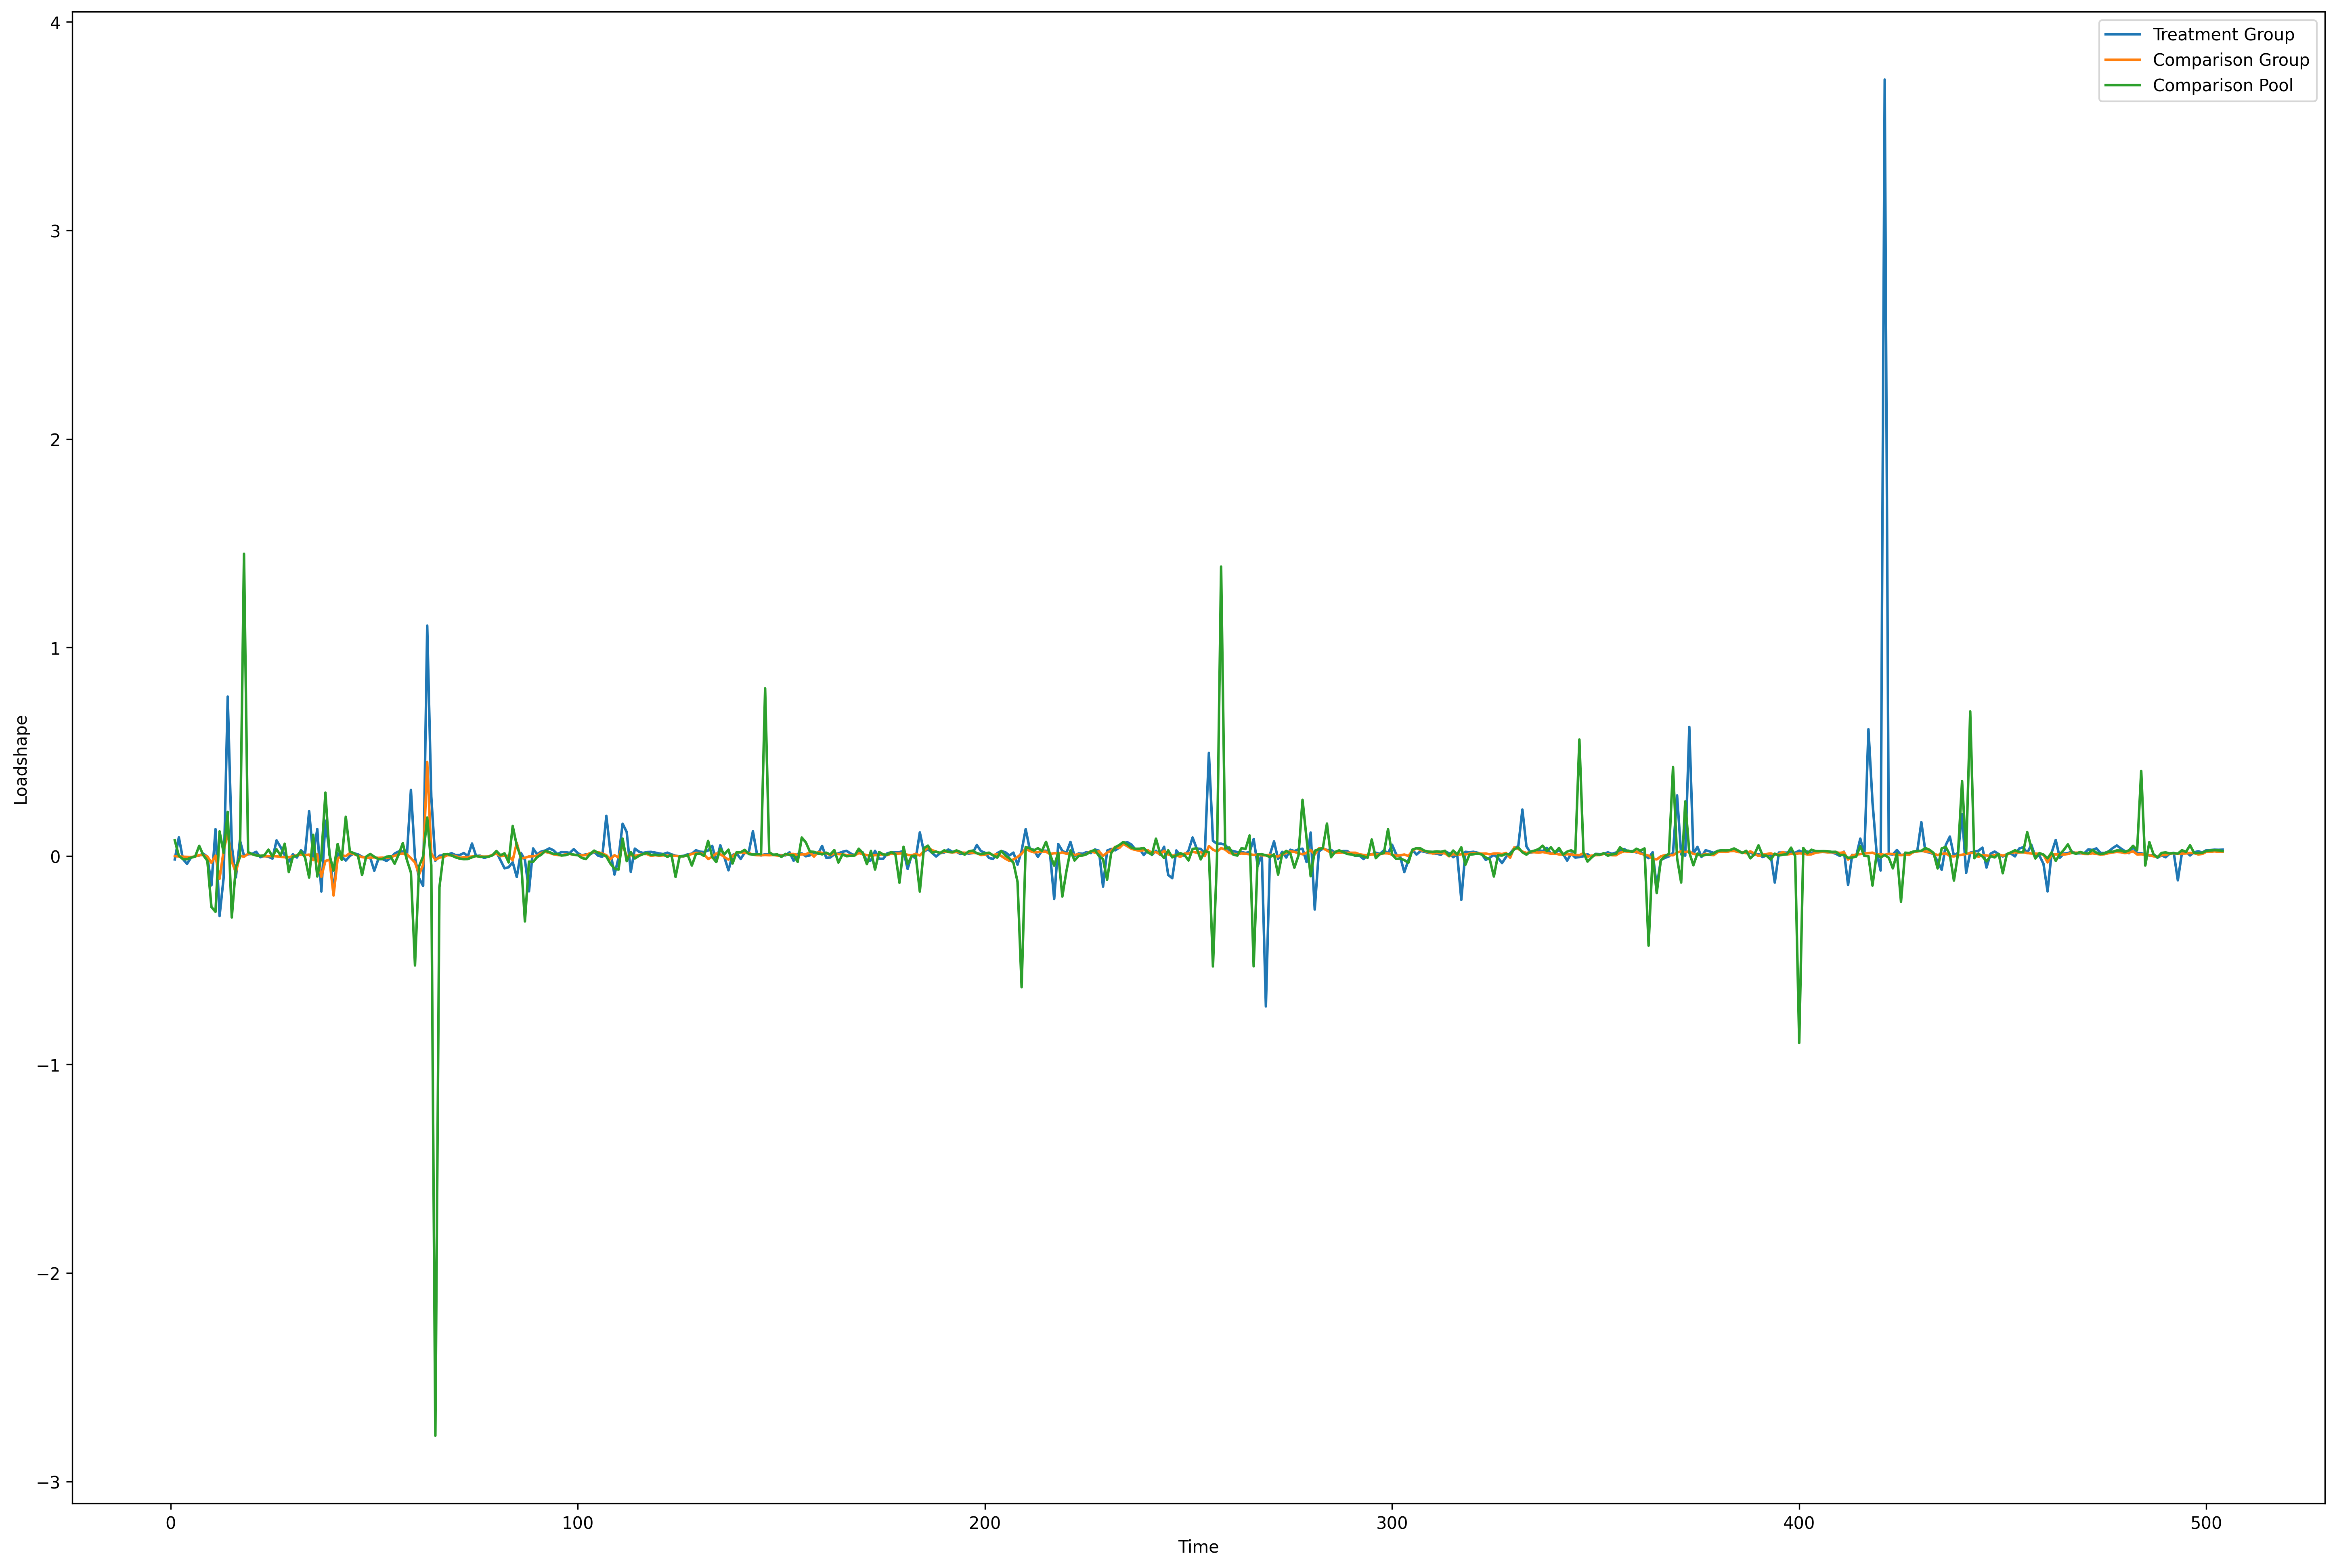

In [5]:
imm.plot_comparison_group_loadshape()